# Spring 2020 - IEOR4718 - Prof. Emanuel Derman


# Systematic Weak Replication of Barrier Options


Traditionally when traders look to hedge an exotic option, they think of Strong Replications, which is either Static or Dynamic. 

Static Hedging is the best hedge one can get: one can buy everything at time 0 and hedge his option perfectly. Dynamic Hedging, on the other hand, is more tricky. One needs to be able to continuously trade for the hedge to be perfect. Not to mention possible transaction costs, errors are unavoidable as one has to trade in discrete time in real life. 

To tackle the numerous hazards of hedging dynamically, traders may be interested by Weak Replication. Weak Replication shares many of the qualities of Static Hedging: weights are fixed, one do not need to trade on a regular basis. However Weak Replication has several drawbacks as well: it will hedge an Exotic Option only approximately and in most of the possible scenarios; it is also model dependent, which can be tricky to implement (which model to choose?).

So this notebook will show how to systematically (weakly) hedge barrier options. 

There exists several types of barrier options. They share similar properties: another option (either a Vanilla Call or Vanilla Put Option) is considered as the underlying option, and if the asset hits a barrier during the life of the option "something" happens:

- **Knock-Out Options** become worthless when the asset hits the barrier. If this is not the case they pay the same payoff as their underlying option. 
- **Kick-In Options** "kick-in" when the asset hits the barrier. This means that the option's payoff is 0 if the asset does not hit the barrier during the life of the option. If the asset hits the barrier, however, the payoff becomes the same as the underlying option of the barrier option.


## Table of content

1. Imports
2. Option Classes
    1. Abstract Option Classes:
        Abstract class for vanilla options and European path-dependent options
    2. Vanilla Options:
        Call & Put options
    3. Barrier Options:
        Basic Knock-In & Knock-Out options
    4. Vanilla Portfolio Class:
        Fixed-weight portfolio of vanilla options.
    5. How to use these classes?
3. Systematic Weak Replication for a barrier option
    1. Initialization
    2. Systematic computation of the hedging portfolio
    3. 2-d graph of the hedging portfolio's value at the barrier
    4. 3-d graph of the hedging portfolio's value ( depends on $(t, S_t)$ )


## Imports

In [1]:
import numpy as np
import pandas as pd
import BSM as bsm
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Option Classes

### Abstract Classes

In [2]:
class EuropeanOption:
    
        
    def payoff(self, arg):
        pass


    def value(self, args):
        pass
    
class ExoticEuropeanOption(EuropeanOption):
    
    
    def payoff(self, path):
        pass
    
    
    def value(self, spot, t, n_time_steps, n_paths, drift, vol): # By Monte-Carlo Simulations

        # Generate n_paths (GBM)
        T = self.option.T
        times = np.linspace(t, T, n_time_steps+1)
        Paths = [ bsm.tools.path(spot, times, drift, vol) for _ in range(n_paths)]
        
        return np.mean([ self.payoff(path) for path in Paths ])
    

### Vanilla Options

In [3]:
class CallOption(EuropeanOption):
    
    def __init__(self, K, T):
        
        self.id = "Call(K={}, T={})".format(K, T)
        self.K = K
        self.T = T
    
    
    def value(self, spot, t, vol, rates=0, dividends=0):
        
        if t<self.T:
            return bsm.call.price(spot, self.K, t, self.T, vol, rates, dividends)
        elif t==self.T:
            return self.payoff(spot)
        else:
            return 0
            
            
    def payoff(self, ST):
        
        return max(ST-self.K, 0)
    

class PutOption(EuropeanOption):
    
    def __init__(self, K, T):
        
        self.id = "Put(K={}, T={})".format(K, T)
        self.K = K
        self.T = T
    
    
    def value(self, spot, t, vol, rates=0, dividends=0):
        
        if t<self.T:
            return bsm.put.price(spot, self.K, t, self.T, vol, rates, dividends)
        elif t==self.T:
            return self.payoff(spot)
        else:
            return 0
            
            
    def payoff(self, ST):
        
        return max(self.K-ST, 0)

### Barrier Options

In [4]:
class KnockInOption(ExoticEuropeanOption):
    
    def __init__(self, spot, barrier, option:EuropeanOption):
        
        tmp = "Up-and-In" if barrier > spot else "Down-and-In"
        self.id = "Knock-In {}(B={}): Underlying option = {}".format(tmp, barrier, option.id)
        self.option = option
        
        self.B = barrier
        if barrier > spot:
            self.is_in = lambda x : x >= self.B
        else:
            self.is_in = lambda x : x <= self.B
    
    
    def payoff(self, path):
        
        path = np.array(path)
        
        if np.any( self.is_in(path) ):
            return self.option.payoff( path[-1] )
        else:
            return 0


class KnockOutOption(ExoticEuropeanOption):
    
    def __init__(self, spot, barrier, option:EuropeanOption):
        
        tmp = "Up-and-Out" if barrier > spot else "Down-and-Out"
        self.id = "Knock-Out {}(B={}): Underlying option = {}".format(tmp, barrier, option.id)
        self.option = option
        
        self.B = barrier
        if barrier > spot:
            self.is_out = lambda x : x >= self.B
        else:
            self.is_out = lambda x : x <= self.B
    
    
    def payoff(self, path):
        
        path = np.array(path)
        
        if np.any( self.is_out(path) ):
            return 0
        else:
            return self.option.payoff( path[-1] )

### Vanilla Portfolio Class

In [5]:
class Portfolio(EuropeanOption):
    
    def __init__(self, weights, options):
        
        self.id = "Portfolio"
        self.w = np.array(weights)
        self.o = options
    
    
    def payoff(self, ST):
        
        return self.w.dot([ option.payoff(ST) for option in self.o ])
    
    
    def value(self, spot, t, vol, rates=0, dividends=0):
        
        return self.w.dot([ option.value(spot, t, vol, rates, dividends) for option in self.o ])

### Example

In [6]:
# Option parameters
spot = 100
strike = 100
barrier = 120
t0 = 0
maturity = 1

# Asset parameters
rates = 0 
dividends = 0
vol = 0.2

# Simulation parameters
n_time_steps = 100
n_paths = 10000
np.random.seed(123)

In [7]:
Call = CallOption(strike, maturity)
Put = PutOption(strike, maturity)
KIC = KnockInOption(spot, barrier, Call) ; KOC = KnockOutOption(spot, barrier, Call)
KIP = KnockInOption(spot, barrier, Put) ; KOP = KnockOutOption(spot, barrier, Put)

In [8]:
tmp = [
    [ strike, Call.value(spot, t0, vol), Put.value(spot, t0, vol)],
    [ barrier, KIC.value(spot, t0, n_time_steps, n_paths, rates - dividends, vol),
     KIP.value(spot, t0, n_time_steps, n_paths, rates - dividends, vol) ],
    [ barrier, KOC.value(spot, t0, n_time_steps, n_paths, rates - dividends, vol),
     KOP.value(spot, t0, n_time_steps, n_paths, rates - dividends, vol) ]
]

pd.DataFrame(tmp,
            index=["Vanilla Option Value", "Knock-In Option Value", "Knock-Out Option Value"],
            columns=["Strike or Barrier", "Call", "Put"])

,Strike or Barrier,Call,Put
Vanilla Option Value,100,7.965567,7.965567
Knock-In Option Value,120,6.935779,0.191441
Knock-Out Option Value,120,1.267467,7.779666


The value of the knock-in option with an underling call option is higher than the value of the knock-in call option. This happens because the path for the option to kick in are mostly the same as the one that give value to the underlying call. 

Same goes for a knock-out put option. The paths that give the more value to the put are the ones that do not knock-out the option. Conversely the paths that give more value to the call option are the one that knock-out the barrier option. Hence the value of this knock-out put option is much higher than the value of this knock-out call option.

## Weak Replication of Barrier Options

### Hyperparameters

In [9]:
barrierOption = KIC

hedgingOptionType = CallOption

hedgingMaturities_a = [ 0.5, 1 ]
hedgingMaturities_b = [ 0.25, 0.5, 0.75, 1 ]

# Options in the hedging portfolio (except the underlying option of the barrier option).
hedgingOptions_a = [ hedgingOptionType(barrierOption.B, T) for T in hedgingMaturities_a ]
hedgingOptions_b = [ hedgingOptionType(barrierOption.B, T) for T in hedgingMaturities_b ]

# Times at which the portfolio's value must be 0. We will call these time "hedging times" from now on.
hedgingTimes_a = [ 0, 0.5 ]
hedgingTimes_b = [ 0, 0.25, 0.5, 0.75 ]

# Rounding the weights of the portfolio. How many digits?
rounding = 2

### Computation of the hedging portfolio

In [10]:
def hedgingPortfolio(barrierOption, hedgingOptions, hedgingTimes):
    
    # Check if there are enough hedging options for hedging times
    assert(len(hedgingOptions)==len(hedgingTimes))
    
    # Matrix of the values of each of the hedging options across all "hedging times", as defined above.
    V = [ [ option.value(barrierOption.B, t, vol, rates, dividends) for option in hedgingOptions ] for t in hedgingTimes ]

    # The entire portfolio (i.e. with the underlying option of the barrier option) must be valued 0 at each hedging times
    B = [ - barrierOption.option.value(barrierOption.B, t, vol, rates, dividends) for t in hedgingTimes ]

    # Solving: W * V = B for W unknown. W will be the weights inside the portfolio.
    W = np.linalg.inv(V).dot(B)
    
    _hedgingOptions = deepcopy(hedgingOptions)
    _hedgingOptions.append(barrierOption.option)
    
    # Simplification of the portfolio's weights.
    W = [ round(w, rounding) for w in W ]
    W.append(1)
    W = np.array(W)

    # Hedging portfolio
    return Portfolio(W, _hedgingOptions)

hedgingPortfolio_a = hedgingPortfolio(barrierOption, hedgingOptions_a, hedgingTimes_a)
hedgingPortfolio_b = hedgingPortfolio(barrierOption, hedgingOptions_b, hedgingTimes_b)

### Value of the hedging portfolio at the barrier

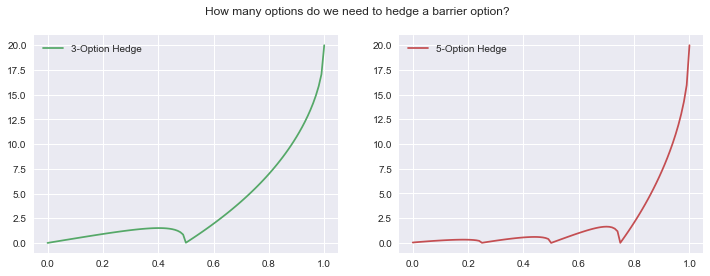

In [11]:
timeAxis = np.linspace(t0, maturity, 101)

mpl.style.use("seaborn")
fig, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("How many options do we need to hedge a barrier option?")

ax_a.plot(timeAxis,
          [hedgingPortfolio_a.value(barrierOption.B, t, vol, rates, dividends) for t in timeAxis],
         'C1',
         label="3-Option Hedge")
ax_a.legend()

ax_b.plot(timeAxis,
          [hedgingPortfolio_b.value(barrierOption.B, t, vol, rates, dividends) for t in timeAxis],
         'C2',
         label="5-Option Hedge")
ax_b.legend()

- It is easy to see that the restrictions on the weights (via the equations above) makes the portfolio equal 0 in each of the hedging times.

- It is also important to note that the hedging portfolio's value will always go up at the barrier. It is not possible to completely hedge the barrier option when time approaches the expiration date. That's why it can be a good idea to close one's position before maturity, to ensure that your hedge is correct.

### Surface value of the hedging portfolio depending on $(t, S_t)$

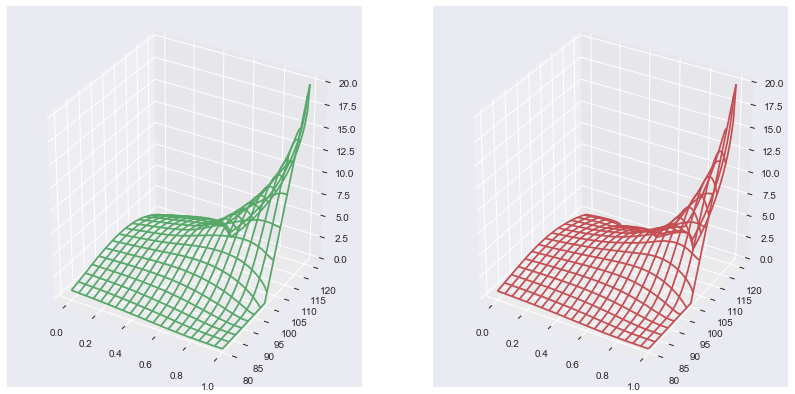

In [12]:
fig = plt.figure(figsize=(14, 7))
ax_a = fig.add_subplot(121, projection='3d')
ax_b = fig.add_subplot(122, projection='3d')

time_axis = np.linspace(0, 1, 101)
ST_axis = np.linspace(80, 120, 41)
nx, ny = len(time_axis), len(ST_axis)

values_a = np.array([ [ hedgingPortfolio_a.value(ST, t, vol, rates, dividends) for t in time_axis] for ST in ST_axis])
values_b = np.array([ [ hedgingPortfolio_b.value(ST, t, vol, rates, dividends) for t in time_axis] for ST in ST_axis])

time_axis, ST_axis = np.meshgrid(time_axis, ST_axis)
ax_a.plot_wireframe(time_axis, ST_axis, values_a, rstride=3, cstride=5, color='C1')
ax_b.plot_wireframe(time_axis, ST_axis, values_b, rstride=3, cstride=5, color='C2')

- Again, we see that the value at the barrier and at maturity goes up, no matter how many options are used for hedging. 

- Also, one can note that the surface is flatter when more options are used for hedging.

## Possible extensions

- Weak Replication for other type of barrier options [(Rebate, Turbo Warrant or Parisian Option - Investopodia)](https://www.investopedia.com/terms/b/barrieroption.asp)

In [3]:
import BSM as bsm
bsm.call.price(100, 100, 0, 1, 0.2, r=0.05)

10.450583572185565